In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [2]:
import warnings
import gc
import tensorflow as tf
import holidays

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from xgboost import plot_importance


In [3]:
def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200)

In [4]:
def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    result = smape(y, y_pred)
    return result

In [5]:
def label_encoder(df):
    country = {c : i for i, c in enumerate(df['country'].unique())}
    store = {s : i for i, s in enumerate(df['store'].unique())}
    product = {p : i for i, p in enumerate(df['product'].unique())}
    df = df.copy()
    df['country'] = df['country'].replace(country)
    df['store'] = df['store'].replace(store)
    df['product'] = df['product'].replace(product)
    return df

In [6]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
def preprocess_dates(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df['date'].dt.weekday
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.day_of_year
    df['is_month_start'] = df['date'].dt.is_month_start
    df['is_month_end'] = df['date'].dt.is_month_end
    df['month'] = df['date'].dt.month
    return df

In [7]:
def preprocess_holidays(df):
    holiday_finland = holidays.CountryHoliday(country='FI', years=[2015, 2016, 2017, 2018, 2019])
    holiday_norway = holidays.CountryHoliday(country='NO', years=[2015, 2016, 2017, 2018, 2019])
    holiday_sweden = holidays.CountryHoliday(country='SE', years=[2015, 2016, 2017, 2018, 2019])
    holidays_fin_nor_swe = holiday_finland.copy()
    holidays_fin_nor_swe.update(holiday_norway)
    holidays_fin_nor_swe.update(holiday_sweden)
    dates = list(holidays_fin_nor_swe.keys())
    dates = sorted(pd.to_datetime(dates))
    df = df.copy()
    df['is_holiday'] = df['date'].apply(lambda x : 1 if x in dates else 0)
    return df

In [8]:
def preprocess_timeseries(df):
    df = df.copy()
    df['sin_day_of_year'] = np.sin(df['day_of_year'])
    df['sin_month'] = np.sin(df['month'])
    return df

In [9]:
seed = 47
warnings.filterwarnings("ignore")

# XGBoost

# Reading the dataset and preprocessing the dataset

In [10]:
train_df = pd.read_csv("/kaggle/input/tabular-playground-series-jan-2022/train.csv", sep=',')
train_df = label_encoder(train_df)
train_df = preprocess_dates(train_df)
train_df = preprocess_holidays(train_df)
train_df = preprocess_timeseries(train_df)
x_train = train_df.drop(['row_id', 'date', 'num_sold'], axis=1)
y_train = train_df['num_sold']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=seed, shuffle=False)

In [11]:
params = {'n_estimators': 200, 
          'max_depth': 23, 
          'subsample': 1.0,
          'eta': 0.3,
          'colsample_bytree': 1.0,
          'gamma': 0.0, 
          'min_child_weight': 1,
          'reg_alpha': 1
         }

model =  XGBRegressor(**params,
                      objective='reg:linear',
                      random_state=seed,
                      early_stopping_rounds=200,
                      verbosity=0)
model.fit(x_train, y_train, verbose=True)
score = evaluate_model(model, x_test, y_test)
print(score)

8.814708291003793


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

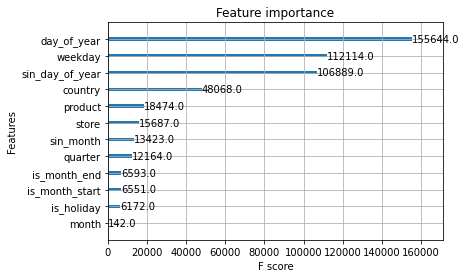

In [12]:
plot_importance(model)

# Submission

In [13]:
del train_df, x_train, y_train, x_test, y_test
gc.collect()

21

In [14]:
test_df = pd.read_csv("/kaggle/input/tabular-playground-series-jan-2022/test.csv", sep=',')
test_df = label_encoder(test_df)
test_df = preprocess_dates(test_df)
test_df = preprocess_holidays(test_df)
test_df = preprocess_timeseries(test_df)
x_test = test_df.drop(['row_id', 'date'], axis=1)

In [15]:
target = model.predict(x_test).squeeze()
row_id =  test_df['row_id'].values
submission = pd.DataFrame({'row_id' : row_id, 'num_sold' : target})

In [16]:
submission.head()

,row_id,num_sold
0,26298,405.198303
1,26299,620.650269
2,26300,176.226227
3,26301,680.844849
4,26302,1032.877441


In [17]:
submission.to_csv('submission.csv', index=False)